In [1]:
import pandas as pd
import numpy as np
import string
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.cluster import KMeans
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
df = pd.read_csv('../dataset/arxiv_sampled.csv')

In [3]:
df.head()

,id,authors,title,categories,abstract,update_date,latest_version_year
0,2110.14541,"Yoel Bokobza, Ron Dabora and Kobi Cohen",Deep Reinforcement Learning for Simultaneous S...,"['cs.IT', 'cs.LG', 'math.IT']",We consider the problem of dynamic spectrum ...,2021-10-28,2021
1,2209.05330,"Erik Fitzke, Florian Niederschuh, and Thomas W...",Generating Functions and Automatic Differentia...,['quant-ph'],A simple and versatile method to simulate th...,2022-09-13,2022
2,2105.12470,"Carlos Vega, Miguel Bello, Diego Porras and Al...",Qubit-photon bound states in topological waveg...,['quant-ph'],Quantum emitters interacting with photonic b...,2021-11-29,2021
3,2205.06071,Rylee Alanza Lyman,On Whitehead's cut vertex lemma,"['math.GR', 'math.GT']",One version of Whitehead's famous cut vertex...,2022-09-13,2022
4,2205.10915,"Chenyang Xu, Ziquan Zhuang",Stable degenerations of singularities,"['math.AG', 'math.AC', 'math.DG']",For any Kawamata log terminal (klt) singular...,2022-05-24,2022


In [4]:
parser = en_core_sci_lg.load()
stop_words = list(STOP_WORDS)
stop_words += ['able', 'ability', 'accord', 'cause']
punctuations = string.punctuation

def tokenizer(s):
    tokens = parser(s)
    all_tokens = []
    for t in tokens:
        token = t.lemma_.lower()
        if token not in stop_words and token not in punctuations\
            and token != '\n':
            all_tokens.append(token)
    return ' '.join(all_tokens)

In [6]:
tqdm.pandas()
df['processed_abstract'] = df.abstract.progress_apply(tokenizer)

100%|█████████████████████████████████████| 50000/50000 [28:55<00:00, 28.82it/s]


In [7]:
corpus = df.processed_abstract.values

vectorizer = TfidfVectorizer(min_df=0.016,
                             max_df=0.05)
doc_term_matrix = vectorizer.fit_transform(corpus)
vec = pd.DataFrame(doc_term_matrix.toarray(),
                   columns=vectorizer.get_feature_names_out())
feature_names = vectorizer.get_feature_names_out()

In [8]:
vec.head()

,100,20,2d,3d,access,account,accurate,accurately,act,action,...,volume,wave,weak,weight,well,wide,widely,year,yield,zero
0,0.0,0.0,0.0,0.0,0.602209,0.000000,0.0,0.0,0.000000,0.092776,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.098619,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.255613,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.311555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
topic_num = 20
lsa = TruncatedSVD(n_components=topic_num)
lsa.fit(doc_term_matrix)

TruncatedSVD(n_components=20)

In [10]:
W = lsa.transform(doc_term_matrix)
H = lsa.components_

In [11]:
topics = []
for i in range(topic_num):
    topics.append([])

HT = np.transpose(H)
    
for i in range(len(HT)):
    l = HT[i].tolist()
    max_index = l.index(max(l))
    topics[max_index].append(feature_names[i])

In [12]:
for i, t in enumerate(topics):
    print(topics[i][:10])

['100', '20', '2d', 'account', 'accurate', 'accurately', 'active', 'adapt', 'adaptive', 'add']
['angle', 'calculation', 'charge', 'coupling', 'dependence', 'electron', 'electronic', 'fluctuation', 'flux', 'hamiltonian']
['algebraic', 'analytic', 'asymptotic', 'certain', 'coefficient', 'compact', 'complete', 'conjecture', 'construction', 'converge']
['binary', 'candidate', 'cluster', 'constrain', 'core', 'early', 'evolution', 'fit', 'formation', 'fraction']
['automatic', 'com', 'content', 'fine', 'github', 'https', 'module', 'pre', 'recognition', 'semantic']
['access', 'activity', 'communication', 'computing', 'demand', 'device', 'distribute', 'experience', 'online', 'platform']
['mathcal']
['answer', 'et', 'orbit', 'relation', 'sequence', 'spin', 'stochastic']
['generation', 'language', 'natural', 'program', 'question', 'resource', 'social']
['3d', 'action', 'agent', 'background', 'black', 'decision', 'entropy', 'environment', 'gravitational', 'gravity']
['cloud', 'tensor', 'user']
['a

In [13]:
Xs = []
for i in range(topic_num):
    Xs.append(W[:, i].tolist())

In [14]:
XsT = np.transpose(Xs)

In [15]:
# tune k
inertia = []

for num_clusters in range(1, 21):
    km = KMeans(n_clusters=num_clusters,
                random_state=42,
                n_init=20)
    km.fit(XsT)
    inertia.append(km.inertia_)

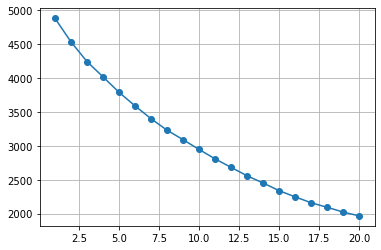

In [16]:
plt.plot(range(1, 21), inertia, marker='o')
plt.grid(True)
plt.show()

In [17]:
km = KMeans(n_clusters=14,
            random_state=42,
            n_init=20)
km.fit(XsT)
clusters = km.labels_

In [18]:
pca = PCA(n_components=2, random_state=42)
pca.fit(W)
W_t = pca.transform(W)

In [19]:
X = []
for i in range(14):
    X.append([])
    
for i in range(50000):
    X[clusters[i]].append(i)

<AxesSubplot:>

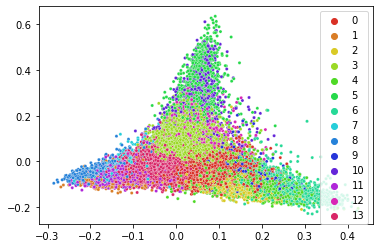

In [20]:
palette = sns.hls_palette(14, l=.5, s=.7)

sns.scatterplot(x=W_t[:, 0],
                y=W_t[:, 1],
                hue=clusters,
                palette=palette,
                s=10)

In [21]:
topic_paper = X[1][:10]
for i in topic_paper:
    print(df.loc[i, 'title'])
    print(df.loc[i, 'categories'])

Deep Reinforcement Learning for Simultaneous Sensing and Channel Access
  in Cognitive Networks
['cs.IT', 'cs.LG', 'math.IT']
Building Flexible, Low-Cost Wireless Access Networks With Magma
['cs.NI']
Automatic Map Generation for Autonomous Driving System Testing
['cs.SE']
Analyzing time series activity of Twitter political spambots
['cs.SI']
Epistemic AI platform accelerates innovation by connecting biomedical
  knowledge
['cs.AI']
DeF-DReL: Systematic Deployment of Serverless Functions in Fog and Cloud
  environments using Deep Reinforcement Learning
['cs.DC', 'cs.AI']
SmashEx: Smashing SGX Enclaves Using Exceptions
['cs.CR']
Leveraging RIS-Enabled Smart Signal Propagation for Solving Infeasible
  Localization Problems
['eess.SP']
Measuring what Really Matters: Optimizing Neural Networks for TinyML
['cs.LG']
Optimizing Intelligent Reflecting Surface-Base Station Association for
  Mobile Networks
['cs.NI', 'cs.SY', 'eess.SY']


In [22]:
topic_paper = X[9][:10]
for i in topic_paper:
    print(df.loc[i, 'title'])
    print(df.loc[i, 'categories'])

Application of Neural Network Machine Learning to Solution of
  Black-Scholes Equation
['math.AP']
The final Kasner regime inside black holes with scalar or vector hair
['hep-th']
Universal Properties of Light Rings for Stationary Axisymmetric
  Spacetimes
['gr-qc']
Wormholes with a warped extra dimension?
['gr-qc']
Nonassociative black holes in R-flux deformed phase spaces and
  relativistic models of G. Perelman thermodynamics
['hep-th']
Are there echoes of gravitational waves?
['gr-qc', 'astro-ph.HE', 'hep-th']
Two-time alternative to the Ashtekar-Olmedo-Singh black hole interior
['gr-qc']
Jet Parameters in the Black-Hole X-Ray Binary MAXI J1820+070
['astro-ph.HE']
The van der Waals-like Phase Transition in the FRW Universe
['gr-qc', 'astro-ph.CO', 'hep-th']
Non-singular "Gauss" black hole from non-locality: a simple model with a
  de Sitter core, mass gap, and no inner horizon
['gr-qc', 'hep-th']


In [23]:
topic_paper = X[3][:10]
for i in topic_paper:
    print(df.loc[i, 'title'])
    print(df.loc[i, 'categories'])

On Whitehead's cut vertex lemma
['math.GR', 'math.GT']
Stable degenerations of singularities
['math.AG', 'math.AC', 'math.DG']
Parameter region for multistationarity in $n-$site phosphorylation
  networks
['q-bio.MN', 'math.AG', 'math.DS']
Bell Nonlocality and the Reality of Quantum Wavefunction
['quant-ph', 'physics.hist-ph']
Embedded antipodal planes and the minimum weight of the dual code of
  points and lines in projective planes of order $p^2$
['math.CO']
Infinite utility: counterparts and ultimate locations
['econ.TH']
A Weak Reverse Holder Inequality for Caloric Measure
['math.AP']
Combinatorics on bounded free Motzkin paths and its applications
['math.CO']
Tensor rank is not multiplicative under the tensor product
['math.AC', 'cs.CC', 'quant-ph']
Persistent sheaf cohomology
['math.AT']
